<a href="https://colab.research.google.com/github/Touchfree-Labz/deeplearning-with-pytorch/blob/main/ConvolutionalNeuralNetwork_CNN_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# convert MNIST image files into a tensor  of 4-dimensions (# of images, height, width, color channels)
transform = transforms.ToTensor()

In [4]:
# train data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16315307.69it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494310.35it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4514083.17it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12080233.84it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [5]:
# test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
# create a small batch size for images ... 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [9]:
# define CNN Model
# describe convolutional layer and what it's doing (2 convolutional layers)
# this is just an example and next stage we'll build t full
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [10]:
# grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [11]:
X_Train.shape

torch.Size([1, 28, 28])

In [12]:
x = X_Train.view(1, 1, 28, 28)

In [13]:
x = F.relu(conv1(x)) # rectified linear unit for our activation funtion

In [14]:
# 1 image, 6 filters we asked for, 26x26 image size reduced after applying default padding
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
# pass thru the pooling layer
x = F.max_pool2d(x,2,2)

In [16]:
# 26 / 3 = 13
x.shape

torch.Size([1, 6, 13, 13])

In [17]:
# second convolutional layer
x = F.relu(conv2(x))

In [18]:
x.shape

torch.Size([1, 16, 11, 11])

In [19]:
x = F.max_pool2d(x,2,2)

In [20]:
# 11 / 2 = 5.5 -> 5
x.shape

torch.Size([1, 16, 5, 5])

In [21]:
# Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    # fully connected layers
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  # forward functions
  def forward(self, X):
    # first pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernal and stride 2

    # second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernal and stride 2

    # re-view to flattern it out
    X = X.view(-1, 16*5*5) # -1 so that we can vary the batch size

    # fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

In [22]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller the learning rate, it's going to take longer to train

In [24]:
import time
start_time = time.time()

# create variables to track the stuff
epochs = 5
train_losses  = []
test_losses   = []
train_correct = []
test_correct  = []

# for loop epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # train
  for b,(X_train, y_train) in enumerate(train_loader):
    b += 1                            # start our batches at 1
    y_pred = model(X_train)           # get the predicted values from the training set. not flattened 2D
    loss = criterion(y_pred, y_train) # how off we are?

    predicted   = torch.max(y_pred.data,1)[1]     # add up the number of preditions. indexed off the first point
    batch_corr  = (predicted == y_train).sum()  # how many we got correct from this batch
    trn_corr   += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b % 600 == 0:
      print(f'epoch: {i} batch: {b} loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # test
  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()

      loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total_time = current_time - start_time
print(f'total time spent: {total_time/60} minutes')

epoch: 0 batch: 600 loss: 0.1599934995174408
epoch: 0 batch: 1200 loss: 0.18979528546333313
epoch: 0 batch: 1800 loss: 0.5580862760543823
epoch: 0 batch: 2400 loss: 0.2070152312517166
epoch: 0 batch: 3000 loss: 0.006888664327561855
epoch: 0 batch: 3600 loss: 0.33112621307373047
epoch: 0 batch: 4200 loss: 0.004664934705942869
epoch: 0 batch: 4800 loss: 0.0020317500457167625
epoch: 0 batch: 5400 loss: 0.06558699160814285
epoch: 0 batch: 6000 loss: 0.000513441045768559
epoch: 1 batch: 600 loss: 0.004773168824613094
epoch: 1 batch: 1200 loss: 0.30684694647789
epoch: 1 batch: 1800 loss: 0.0025840331800282
epoch: 1 batch: 2400 loss: 0.004851708188652992
epoch: 1 batch: 3000 loss: 0.05095291882753372
epoch: 1 batch: 3600 loss: 0.29904529452323914
epoch: 1 batch: 4200 loss: 0.020275484770536423
epoch: 1 batch: 4800 loss: 0.0018002415308728814
epoch: 1 batch: 5400 loss: 0.0003511425748001784
epoch: 1 batch: 6000 loss: 0.16817066073417664
epoch: 2 batch: 600 loss: 0.044435493648052216
epoch: 2 b

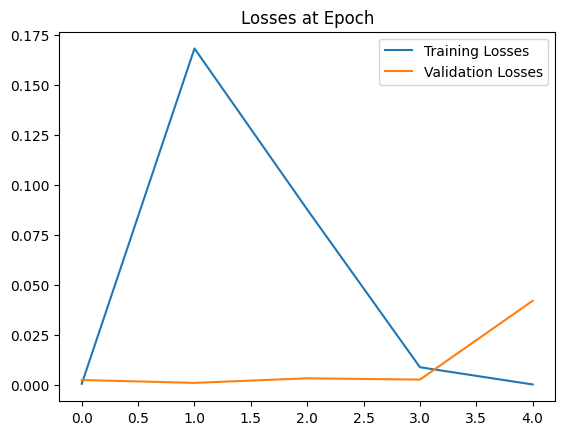

In [25]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Losses")
plt.plot(test_losses, label="Validation Losses")
plt.title("Losses at Epoch")
plt.legend()

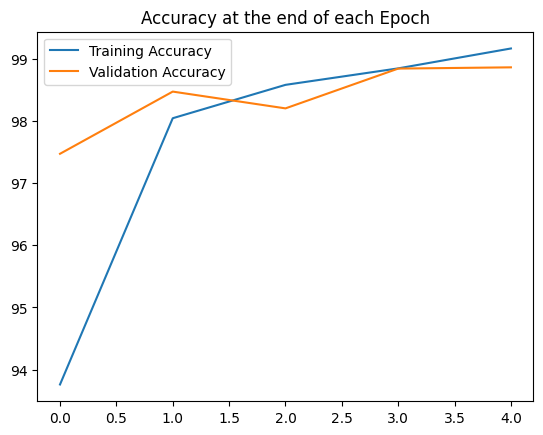

In [26]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [27]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [28]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

In [30]:
correct.item()
# https://www.youtube.com/watch?v=aQUPnfRZFDQ&list=PLCC34OHNcOtpcgR9LEYSdi9r7XIbpkpK1&index=19

9886

In [33]:
# test new image
# test_data[4143] # tensor with an image in it... at the end, it shows the label
# test_data[4143][0] #data
test_data[4143][0].reshape(28,28) # reshaped

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

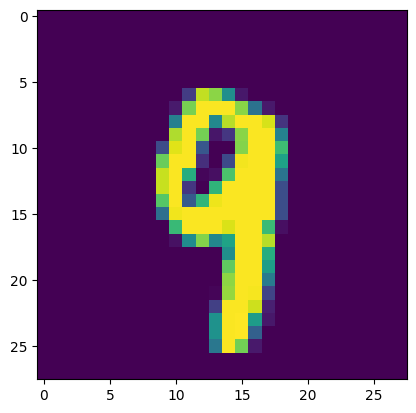

In [34]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [35]:
# pass image thru a model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1, 1, 28, 28)) # batch size 1, color channel 1, size 28x28

In [36]:
new_prediction

tensor([[-2.6323e+01, -2.2043e+01, -2.5815e+01, -1.6283e+01, -1.1452e+01,
         -2.2503e+01, -3.8594e+01, -1.5411e+01, -1.7841e+01, -1.0967e-05]])

In [37]:
new_prediction.argmax()

tensor(9)